In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('../단국대(사용중)')
feature_dir = Path('../단국대(사용중)')
sub_dir = Path('../단국대(사용중)')
val_dir = Path('../단국대(사용중)')
tst_dir = Path('../단국대(사용중)')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 142)


,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,u_r,u_g,g_r,g_z,g_i,d_dered_u,d_dered_g,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,dered_u_min,dered_u_diff,dered_u_sum,dered_g_max,dered_g_min,dered_g_diff,dered_g_std,dered_g_sum,dered_r_max,dered_r_min,dered_r_diff,dered_r_std,dered_r_sum,dered_i_max,dered_i_min,dered_i_diff,dered_i_std,dered_z_max,dered_z_diff,dered_z_std,dered_z_sum,d_dered_u_d_dered_g_diff,d_dered_u_dered_r_diff,d_dered_u_d_dered_iz_diff,d_dered_u_d_dered_ig_diff,d_dered_u_d_dered_i_diff,d_dered_u_dered_i_diff,...,d_dered_r_dered_i_diff,d_dered_r_d_dered_zg_diff,dered_r_d_dered_iz_diff,dered_r_d_dered_i_diff,dered_r_dered_i_diff,dered_r_d_dered_zg_diff,dered_r_d_dered_z_diff,dered_r_dered_z_diff,d_dered_iz_d_dered_ig_diff,d_dered_iz_d_dered_i_diff,d_dered_iz_d_dered_zg_diff,d_dered_iz_d_dered_z_diff,d_dered_iz_dered_z_diff,d_dered_ig_d_dered_i_diff,d_dered_ig_dered_i_diff,d_dered_ig_d_dered_zg_diff,d_dered_ig_d_dered_z_diff,d_dered_ig_dered_z_diff,d_dered_i_d_dered_zg_diff,d_dered_i_d_dered_z_diff,d_dered_i_dered_z_diff,dered_i_d_dered_z_diff,dered_i_dered_z_diff,d_dered_zg_dered_z_diff,dered_u_dered_g_min_diff,dered_u_dered_g_sum_diff,dered_u_dered_r_max_diff,dered_u_dered_r_min_diff,dered_u_dered_r_sum_diff,dered_u_dered_i_sum_diff,dered_u_dered_z_max_diff,dered_u_dered_z_min_diff,dered_u_dered_z_sum_diff,dered_g_dered_r_max_diff,dered_g_dered_r_min_diff,dered_g_dered_r_sum_diff,dered_g_dered_i_max_diff,dered_g_dered_i_min_diff,dered_g_dered_i_sum_diff,dered_g_dered_z_max_diff,dered_g_dered_z_sum_diff,dered_r_dered_i_max_diff,dered_r_dered_i_min_diff,dered_r_dered_i_sum_diff,dered_r_dered_z_max_diff,dered_r_dered_z_min_diff,dered_r_dered_z_sum_diff,dered_i_dered_z_max_diff,dered_i_dered_z_min_diff,dered_i_dered_z_sum_diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,4.2545,2.9272,1.3273,3.3972,2.6643,0.9940,0.9961,0.9977,0.9982,0.8704,0.8347,1.1210,1.0428,1.0000,0.9940,22.1303,24.1183,20.2578,0.9961,19.2617,13.6201,21.2539,18.9551,0.9971,17.9580,10.3325,21.0733,17.6321,0.8704,16.7617,8.3312,16.9089,16.0743,9.2336,18.7418,-0.0021,-17.9611,-0.0488,0.1236,-0.0037,-16.6381,...,-16.6350,0.1625,17.9124,17.9574,1.3230,18.1204,17.9569,2.0462,0.1724,0.0451,0.2081,0.0446,-15.8662,-0.1273,-16.7617,0.0357,-0.1278,-16.0386,0.1630,-0.0005,-15.9112,16.6339,0.7232,-16.0743,-0.0021,2.8643,4.1691,-0.0031,3.0450,3.5753,6.2153,0.1593,5.3764,1.3027,-0.0010,0.1806,2.6257,0.1257,0.7109,3.3488,2.5121,1.3230,0.1268,0.5303,2.0462,0.1625,2.3315,0.7232,0.0357,1.8012
1,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,1.5997,0.9902,0.6096,0.8930,0.7935,0.9943,0.9959,0.9976,0.9974,0.9451,0.9379,1.0211,1.0077,1.0000,0.9943,13.9721,15.9607,14.0045,0.9959,13.0086,9.1985,15.0004,13.4114,0.9970,12.4144,7.1605,15.4294,13.2363,0.9451,12.2911,6.1264,13.1347,12.1968,7.0247,15.0700,-0.0016,-12.4171,-0.0134,0.0492,-0.0033,-12.2419,...,-12.2393,0.0591,12.4037,12.4138,0.1751,12.4735,12.4140,0.2767,0.0626,0.0102,0.0698,0.0103,-12.1269,-0.0524,-12.2911,0.0073,-0.0523,-12.1895,0.0597,0.0002,-12.1371,12.2389,0.1016,-12.1968,-0.0016,0.9603,1.5550,-0.0026,0.5313,-0.2260,1.8317,0.0564,0.8908,0.5931,-0.0010,-0.4290,0.7683,0.0508,-1.1863,0.8698,-0.0695,0.1751,0.0518,-0.7573,0.2767,0.0591,0.3594,0.1016,0.0073,1.1167
2,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,1.2501,0.9610,0.2891,0.4754,0.4319,0.9894,0.9912,0.9953,0.9965,0.9767,0.9751,1.0094,1.0017,1.0000,0.9894,15.6183,17.5970,15.6866,0.9912,14.6954,10.3912,16.6778,15.4400,0.9938,14.4462,8.3360,17.4433,15.3217,0.9767,14.3450,7.1652,15.2961,14.3210,8.2621,17.2677,-0.0019,-14.4507,-0.0123,0.0126,-0.0060,-14.3324,...,-14.3279,0.0187,14.4384,14.4447,0.1183,14.4649,14.4436,0.1440,0.0249,0.0063,0.0266,0.0052,-14.2944,-0.0186,-14.3450,0.0016,-0.0197,-14.3193,0.0202,-0.0011,-14.3007,

In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 141) (80000, 141)


In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [9]:
params = { 
    "objective": "multiclass",
    "n_estimators": 10000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])}

In [10]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|████████████████████████████████████████████████| 10/10 [08:48<00:00, 52.80s/trial, best loss: 0.1572410008496388]
{'objective': 'multiclass', 'n_estimators': 10000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.8, 'learning_rate': 0.027932814926374023, 'min_child_samples': 10, 'num_leaves': 63, 'subsample': 0.8}


In [11]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [12]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.946305
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.907218
[3]	valid_0's multi_logloss: 0.874641
[4]	valid_0's multi_logloss: 0.842816
[5]	valid_0's multi_logloss: 0.810792
[6]	valid_0's multi_logloss: 0.780851
[7]	valid_0's multi_logloss: 0.754607
[8]	valid_0's multi_logloss: 0.729951
[9]	valid_0's multi_logloss: 0.706568
[10]	valid_0's multi_logloss: 0.682734
[11]	valid_0's multi_logloss: 0.660221
[12]	valid_0's multi_logloss: 0.639921
[13]	valid_0's multi_logloss: 0.620094
[14]	valid_0's multi_logloss: 0.600841
[15]	valid_0's multi_logloss: 0.582621
[16]	valid_0's multi_logloss: 0.565702
[17]	valid_0's multi_logloss: 0.549261
[18]	valid_0's multi_logloss: 0.534798
[19]	valid_0's multi_logloss: 0.519839
[20]	valid_0's multi_logloss: 0.505576
[21]	valid_0's multi_logloss: 0.492004
[22]	valid_0's multi_logloss: 0.480082
[23]	valid_0's multi_logloss: 0.46765
[24]	valid_0's multi_loglos

[207]	valid_0's multi_logloss: 0.157925
[208]	valid_0's multi_logloss: 0.157866
[209]	valid_0's multi_logloss: 0.157834
[210]	valid_0's multi_logloss: 0.157769
[211]	valid_0's multi_logloss: 0.157732
[212]	valid_0's multi_logloss: 0.157677
[213]	valid_0's multi_logloss: 0.157634
[214]	valid_0's multi_logloss: 0.157589
[215]	valid_0's multi_logloss: 0.157553
[216]	valid_0's multi_logloss: 0.157498
[217]	valid_0's multi_logloss: 0.157455
[218]	valid_0's multi_logloss: 0.157422
[219]	valid_0's multi_logloss: 0.157357
[220]	valid_0's multi_logloss: 0.157332
[221]	valid_0's multi_logloss: 0.157272
[222]	valid_0's multi_logloss: 0.15723
[223]	valid_0's multi_logloss: 0.15719
[224]	valid_0's multi_logloss: 0.157145
[225]	valid_0's multi_logloss: 0.157088
[226]	valid_0's multi_logloss: 0.157054
[227]	valid_0's multi_logloss: 0.157012
[228]	valid_0's multi_logloss: 0.156945
[229]	valid_0's multi_logloss: 0.156918
[230]	valid_0's multi_logloss: 0.156896
[231]	valid_0's multi_logloss: 0.156859
[2

[412]	valid_0's multi_logloss: 0.154773
[413]	valid_0's multi_logloss: 0.154773
[414]	valid_0's multi_logloss: 0.154765
[415]	valid_0's multi_logloss: 0.154757
[416]	valid_0's multi_logloss: 0.15475
[417]	valid_0's multi_logloss: 0.154758
[418]	valid_0's multi_logloss: 0.154756
[419]	valid_0's multi_logloss: 0.154754
[420]	valid_0's multi_logloss: 0.15475
[421]	valid_0's multi_logloss: 0.154733
[422]	valid_0's multi_logloss: 0.154727
[423]	valid_0's multi_logloss: 0.154719
[424]	valid_0's multi_logloss: 0.154719
[425]	valid_0's multi_logloss: 0.154706
[426]	valid_0's multi_logloss: 0.154713
[427]	valid_0's multi_logloss: 0.15471
[428]	valid_0's multi_logloss: 0.154714
[429]	valid_0's multi_logloss: 0.154715
[430]	valid_0's multi_logloss: 0.154709
[431]	valid_0's multi_logloss: 0.1547
[432]	valid_0's multi_logloss: 0.15469
[433]	valid_0's multi_logloss: 0.154683
[434]	valid_0's multi_logloss: 0.154682
[435]	valid_0's multi_logloss: 0.154681
[436]	valid_0's multi_logloss: 0.154674
[437]	

[94]	valid_0's multi_logloss: 0.189992
[95]	valid_0's multi_logloss: 0.189068
[96]	valid_0's multi_logloss: 0.188168
[97]	valid_0's multi_logloss: 0.187307
[98]	valid_0's multi_logloss: 0.186478
[99]	valid_0's multi_logloss: 0.18566
[100]	valid_0's multi_logloss: 0.184865
[101]	valid_0's multi_logloss: 0.184135
[102]	valid_0's multi_logloss: 0.183381
[103]	valid_0's multi_logloss: 0.18266
[104]	valid_0's multi_logloss: 0.181971
[105]	valid_0's multi_logloss: 0.181369
[106]	valid_0's multi_logloss: 0.180716
[107]	valid_0's multi_logloss: 0.180078
[108]	valid_0's multi_logloss: 0.179478
[109]	valid_0's multi_logloss: 0.178867
[110]	valid_0's multi_logloss: 0.178286
[111]	valid_0's multi_logloss: 0.177775
[112]	valid_0's multi_logloss: 0.17724
[113]	valid_0's multi_logloss: 0.176747
[114]	valid_0's multi_logloss: 0.176244
[115]	valid_0's multi_logloss: 0.175748
[116]	valid_0's multi_logloss: 0.175269
[117]	valid_0's multi_logloss: 0.174779
[118]	valid_0's multi_logloss: 0.174348
[119]	val

[300]	valid_0's multi_logloss: 0.156696
[301]	valid_0's multi_logloss: 0.156676
[302]	valid_0's multi_logloss: 0.15667
[303]	valid_0's multi_logloss: 0.156673
[304]	valid_0's multi_logloss: 0.15667
[305]	valid_0's multi_logloss: 0.156653
[306]	valid_0's multi_logloss: 0.156648
[307]	valid_0's multi_logloss: 0.156641
[308]	valid_0's multi_logloss: 0.156634
[309]	valid_0's multi_logloss: 0.156614
[310]	valid_0's multi_logloss: 0.156601
[311]	valid_0's multi_logloss: 0.156587
[312]	valid_0's multi_logloss: 0.156574
[313]	valid_0's multi_logloss: 0.156575
[314]	valid_0's multi_logloss: 0.15656
[315]	valid_0's multi_logloss: 0.156553
[316]	valid_0's multi_logloss: 0.156528
[317]	valid_0's multi_logloss: 0.156508
[318]	valid_0's multi_logloss: 0.15649
[319]	valid_0's multi_logloss: 0.156486
[320]	valid_0's multi_logloss: 0.156469
[321]	valid_0's multi_logloss: 0.156461
[322]	valid_0's multi_logloss: 0.15646
[323]	valid_0's multi_logloss: 0.15645
[324]	valid_0's multi_logloss: 0.156449
[325]	

[73]	valid_0's multi_logloss: 0.216883
[74]	valid_0's multi_logloss: 0.21509
[75]	valid_0's multi_logloss: 0.213369
[76]	valid_0's multi_logloss: 0.2117
[77]	valid_0's multi_logloss: 0.210085
[78]	valid_0's multi_logloss: 0.208548
[79]	valid_0's multi_logloss: 0.20714
[80]	valid_0's multi_logloss: 0.205832
[81]	valid_0's multi_logloss: 0.204549
[82]	valid_0's multi_logloss: 0.203134
[83]	valid_0's multi_logloss: 0.201778
[84]	valid_0's multi_logloss: 0.200542
[85]	valid_0's multi_logloss: 0.199414
[86]	valid_0's multi_logloss: 0.198184
[87]	valid_0's multi_logloss: 0.196978
[88]	valid_0's multi_logloss: 0.195972
[89]	valid_0's multi_logloss: 0.194857
[90]	valid_0's multi_logloss: 0.193841
[91]	valid_0's multi_logloss: 0.192875
[92]	valid_0's multi_logloss: 0.191875
[93]	valid_0's multi_logloss: 0.190994
[94]	valid_0's multi_logloss: 0.190167
[95]	valid_0's multi_logloss: 0.189282
[96]	valid_0's multi_logloss: 0.188379
[97]	valid_0's multi_logloss: 0.187515
[98]	valid_0's multi_logloss:

[280]	valid_0's multi_logloss: 0.157712
[281]	valid_0's multi_logloss: 0.157683
[282]	valid_0's multi_logloss: 0.157665
[283]	valid_0's multi_logloss: 0.157653
[284]	valid_0's multi_logloss: 0.157639
[285]	valid_0's multi_logloss: 0.157616
[286]	valid_0's multi_logloss: 0.157603
[287]	valid_0's multi_logloss: 0.157599
[288]	valid_0's multi_logloss: 0.157589
[289]	valid_0's multi_logloss: 0.157584
[290]	valid_0's multi_logloss: 0.157572
[291]	valid_0's multi_logloss: 0.157536
[292]	valid_0's multi_logloss: 0.157517
[293]	valid_0's multi_logloss: 0.157504
[294]	valid_0's multi_logloss: 0.157499
[295]	valid_0's multi_logloss: 0.157484
[296]	valid_0's multi_logloss: 0.157475
[297]	valid_0's multi_logloss: 0.157468
[298]	valid_0's multi_logloss: 0.157463
[299]	valid_0's multi_logloss: 0.157461
[300]	valid_0's multi_logloss: 0.157448
[301]	valid_0's multi_logloss: 0.15743
[302]	valid_0's multi_logloss: 0.157432
[303]	valid_0's multi_logloss: 0.157429
[304]	valid_0's multi_logloss: 0.157431
[

[45]	valid_0's multi_logloss: 0.299563
[46]	valid_0's multi_logloss: 0.295258
[47]	valid_0's multi_logloss: 0.290761
[48]	valid_0's multi_logloss: 0.286302
[49]	valid_0's multi_logloss: 0.282279
[50]	valid_0's multi_logloss: 0.278146
[51]	valid_0's multi_logloss: 0.274178
[52]	valid_0's multi_logloss: 0.270698
[53]	valid_0's multi_logloss: 0.266962
[54]	valid_0's multi_logloss: 0.26357
[55]	valid_0's multi_logloss: 0.260138
[56]	valid_0's multi_logloss: 0.256831
[57]	valid_0's multi_logloss: 0.253605
[58]	valid_0's multi_logloss: 0.251026
[59]	valid_0's multi_logloss: 0.248143
[60]	valid_0's multi_logloss: 0.245225
[61]	valid_0's multi_logloss: 0.242425
[62]	valid_0's multi_logloss: 0.239731
[63]	valid_0's multi_logloss: 0.237136
[64]	valid_0's multi_logloss: 0.234815
[65]	valid_0's multi_logloss: 0.232394
[66]	valid_0's multi_logloss: 0.230253
[67]	valid_0's multi_logloss: 0.227989
[68]	valid_0's multi_logloss: 0.225809
[69]	valid_0's multi_logloss: 0.223867
[70]	valid_0's multi_loglo

[252]	valid_0's multi_logloss: 0.157266
[253]	valid_0's multi_logloss: 0.157245
[254]	valid_0's multi_logloss: 0.157227
[255]	valid_0's multi_logloss: 0.157209
[256]	valid_0's multi_logloss: 0.157174
[257]	valid_0's multi_logloss: 0.157149
[258]	valid_0's multi_logloss: 0.157123
[259]	valid_0's multi_logloss: 0.157096
[260]	valid_0's multi_logloss: 0.157072
[261]	valid_0's multi_logloss: 0.157035
[262]	valid_0's multi_logloss: 0.157016
[263]	valid_0's multi_logloss: 0.15698
[264]	valid_0's multi_logloss: 0.156948
[265]	valid_0's multi_logloss: 0.156929
[266]	valid_0's multi_logloss: 0.156912
[267]	valid_0's multi_logloss: 0.156899
[268]	valid_0's multi_logloss: 0.156889
[269]	valid_0's multi_logloss: 0.156861
[270]	valid_0's multi_logloss: 0.15684
[271]	valid_0's multi_logloss: 0.156816
[272]	valid_0's multi_logloss: 0.156811
[273]	valid_0's multi_logloss: 0.156799
[274]	valid_0's multi_logloss: 0.156786
[275]	valid_0's multi_logloss: 0.156775
[276]	valid_0's multi_logloss: 0.156761
[2

[458]	valid_0's multi_logloss: 0.155289
[459]	valid_0's multi_logloss: 0.155288
[460]	valid_0's multi_logloss: 0.15529
[461]	valid_0's multi_logloss: 0.155277
[462]	valid_0's multi_logloss: 0.155281
[463]	valid_0's multi_logloss: 0.155273
[464]	valid_0's multi_logloss: 0.155269
[465]	valid_0's multi_logloss: 0.155269
[466]	valid_0's multi_logloss: 0.15527
[467]	valid_0's multi_logloss: 0.155263
[468]	valid_0's multi_logloss: 0.155263
[469]	valid_0's multi_logloss: 0.15526
[470]	valid_0's multi_logloss: 0.15525
[471]	valid_0's multi_logloss: 0.155235
[472]	valid_0's multi_logloss: 0.155233
[473]	valid_0's multi_logloss: 0.15521
[474]	valid_0's multi_logloss: 0.155209
[475]	valid_0's multi_logloss: 0.1552
[476]	valid_0's multi_logloss: 0.155201
[477]	valid_0's multi_logloss: 0.155207
[478]	valid_0's multi_logloss: 0.155204
[479]	valid_0's multi_logloss: 0.155211
[480]	valid_0's multi_logloss: 0.155207
[481]	valid_0's multi_logloss: 0.155201
[482]	valid_0's multi_logloss: 0.155205
[483]	v

[115]	valid_0's multi_logloss: 0.173917
[116]	valid_0's multi_logloss: 0.173438
[117]	valid_0's multi_logloss: 0.172964
[118]	valid_0's multi_logloss: 0.172526
[119]	valid_0's multi_logloss: 0.17214
[120]	valid_0's multi_logloss: 0.17172
[121]	valid_0's multi_logloss: 0.171286
[122]	valid_0's multi_logloss: 0.170885
[123]	valid_0's multi_logloss: 0.170489
[124]	valid_0's multi_logloss: 0.170093
[125]	valid_0's multi_logloss: 0.169694
[126]	valid_0's multi_logloss: 0.169351
[127]	valid_0's multi_logloss: 0.168976
[128]	valid_0's multi_logloss: 0.168609
[129]	valid_0's multi_logloss: 0.168303
[130]	valid_0's multi_logloss: 0.167974
[131]	valid_0's multi_logloss: 0.167714
[132]	valid_0's multi_logloss: 0.167423
[133]	valid_0's multi_logloss: 0.167186
[134]	valid_0's multi_logloss: 0.166911
[135]	valid_0's multi_logloss: 0.166649
[136]	valid_0's multi_logloss: 0.166438
[137]	valid_0's multi_logloss: 0.166204
[138]	valid_0's multi_logloss: 0.165944
[139]	valid_0's multi_logloss: 0.165662
[1

[322]	valid_0's multi_logloss: 0.154733
[323]	valid_0's multi_logloss: 0.154727
[324]	valid_0's multi_logloss: 0.154713
[325]	valid_0's multi_logloss: 0.154697
[326]	valid_0's multi_logloss: 0.154681
[327]	valid_0's multi_logloss: 0.154677
[328]	valid_0's multi_logloss: 0.15467
[329]	valid_0's multi_logloss: 0.154662
[330]	valid_0's multi_logloss: 0.15465
[331]	valid_0's multi_logloss: 0.154638
[332]	valid_0's multi_logloss: 0.154638
[333]	valid_0's multi_logloss: 0.154623
[334]	valid_0's multi_logloss: 0.154611
[335]	valid_0's multi_logloss: 0.154603
[336]	valid_0's multi_logloss: 0.154598
[337]	valid_0's multi_logloss: 0.154588
[338]	valid_0's multi_logloss: 0.154576
[339]	valid_0's multi_logloss: 0.154564
[340]	valid_0's multi_logloss: 0.154556
[341]	valid_0's multi_logloss: 0.154552
[342]	valid_0's multi_logloss: 0.154551
[343]	valid_0's multi_logloss: 0.154545
[344]	valid_0's multi_logloss: 0.154542
[345]	valid_0's multi_logloss: 0.154532
[346]	valid_0's multi_logloss: 0.15451
[34

In [13]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.4944%


In [14]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [15]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

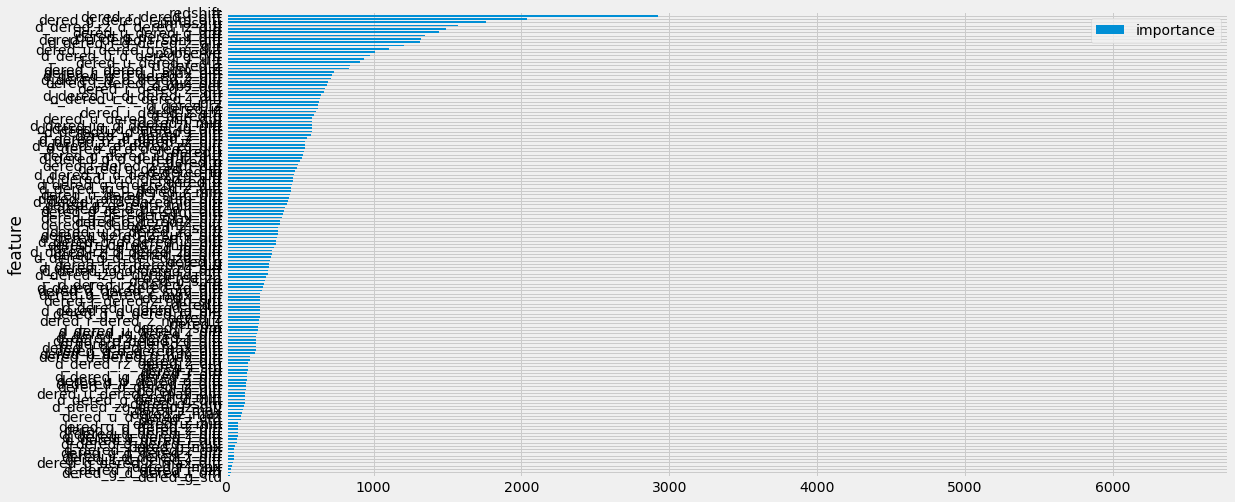

In [16]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [17]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [18]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [19]:
sub[target_col].value_counts()

2    40693
0    29976
1     9331
Name: class, dtype: int64

In [20]:
sub.to_csv(sub_file)